# Problem Statement:

#### Pneumonia is a significant global health challenge, responsible for high rates of morbidity and mortality, particularly among vulnerable populations. Traditional diagnosis via clinical evaluation and radiological interpretations of chest X-rays can be time-consuming, subjective, and limited by human variability. There is an urgent need for automated, accurate, and scalable diagnostic solutions to improve early detection and treatment outcomes.

#### This project aims to develop a deep learning-based system for automated classification of chest X-ray images into 'Normal' or 'Pneumonia' categories, utilizing Convolutional Neural Networks (CNNs) and hyperparameter optimization techniques. By leveraging medical image analysis, the objective is to enhance diagnostic accuracy, reduce dependency on manual interpretation, and support clinical decision-making for pneumonia detection.

In [ ]:
! pip install keras-tuner

# Import Necessary liberaries

In [ ]:
# Basic libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CNN libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metric Libraries
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation
Set data directories


In [ ]:
# data directory path
train_dir = '/content/drive/MyDrive/covid_xray_dataset/train'
test_dir = '/content/drive/MyDrive/covid_xray_dataset/test'

### Build dataframe from directories

In [ ]:
# getting the training data

def create_df(data_path):

    file_path = []
    file_label = []

    for inst in os.listdir(data_path):
        f_path = os.path.join(data_path, inst)
        if os.path.isdir(f_path):
            images = os.listdir(f_path)
            for img in images:
                img_path = os.path.join(f_path, img)
                file_path.append(img_path)
                file_label.append(inst)

    file_series = pd.Series(file_path, name='FilePath')
    label_series = pd.Series(file_label, name='Labels')

    return pd.concat([file_series, label_series], axis=1)

### Create train and test DataFrames

In [ ]:
# creating pandas serires for train and test data
train_df = create_df(train_dir)
test_df = create_df(test_dir)

In [ ]:
# train data sample
train_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
1,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
2,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
3,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
4,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL


In [ ]:
# test data sample
test_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/covid_xray_dataset/test...,PNEUMONIA
1,/content/drive/MyDrive/covid_xray_dataset/test...,PNEUMONIA
2,/content/drive/MyDrive/covid_xray_dataset/test...,PNEUMONIA
3,/content/drive/MyDrive/covid_xray_dataset/test...,PNEUMONIA
4,/content/drive/MyDrive/covid_xray_dataset/test...,PNEUMONIA


In [ ]:
# read a file path
train_df['FilePath'][0]

'/content/drive/MyDrive/covid_xray_dataset/train/NORMAL/IM-0013-0001.jpeg'

In [ ]:
# creating syn data by a data agumentation
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
1,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
2,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
3,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
4,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL


In [ ]:
# data generator

# training
train_generator = train_datagen.flow_from_dataframe(
                    dataframe = train_df,
                    x_col = 'FilePath',
                    y_col = 'Labels',
                    target_size = (224, 224),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

# testing
test_generator = test_datagen.flow_from_dataframe(
                    dataframe = test_df,
                    x_col = 'FilePath',
                    y_col = 'Labels',
                    target_size = (224, 224),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = False)

Found 148 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


## Model Building & Hyperparameter Tuning

In [ ]:
# CNN architecture

def build_model(hp):
    model = Sequential([
        Conv2D(filters = hp.Int('con1_filter', min_value=32, max_value=128, step=8),
               kernel_size = hp.Choice('con1_kernel', values=[3,4,5,6,7]),
               activation = hp.Choice('con1_activation', ['relu', 'tanh']),
               input_shape = (224, 224, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(filters = hp.Int('con2_filter', min_value=32, max_value=68, step=8),
               kernel_size = hp.Choice('con2_kernel', values=[2,3,4]),
               activation = hp.Choice('con2_activation', ['relu', 'tanh']),
               padding = 'same'),
        MaxPooling2D((2, 2)),

        Conv2D(filters = hp.Int('con3_filter', min_value=32, max_value=68, step=8),
               kernel_size = hp.Choice('con3_kernel', values=[2,3,4]),
               activation = hp.Choice('con3_activation', ['relu', 'tanh']),
               padding = 'same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(units=hp.Int('dense1_units', min_value=120, max_value=256, step=8),
              activation = 'relu'),
        Dense(units=hp.Int('dense2_units', min_value=60, max_value=120, step=8),
              activation = 'relu'),
        Dense(2, activation='sigmoid')
    ])

    # model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Tuner for the function
tuner = RandomSearch(hypermodel = build_model,
                     objective = 'accuracy',
                     max_trials = 5,
                     project_name = 'Pneumonia_Prediction')

In [ ]:
# using the tuner to search hyper parameters with image datagenerator
tuner.search(train_generator, epochs=5, batch_size=32, validation_data=test_generator)

Trial 5 Complete [00h 01m 11s]
accuracy: 0.7229729890823364

Best accuracy So Far: 0.7702702879905701
Total elapsed time: 00h 06m 07s


In [ ]:
# best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# summary of the best model
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 104)  │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 104)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 56)   │        93,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 48)     │        24,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 184)            │     6,438,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 76)             │        14,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,573,318 (25.08 MB)

 Trainable params: 6,573,318 (25.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tuner.results_summary()

Results summary
Results in ./Pneumonia_Prediction
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 1 summary
Hyperparameters:
con1_filter: 104
con1_kernel: 3
con1_activation: tanh
con2_filter: 56
con2_kernel: 4
con2_activation: tanh
con3_filter: 48
con3_kernel: 3
con3_activation: relu
dense1_units: 184
dense2_units: 76
Score: 0.7702702879905701

Trial 2 summary
Hyperparameters:
con1_filter: 88
con1_kernel: 7
con1_activation: relu
con2_filter: 48
con2_kernel: 3
con2_activation: relu
con3_filter: 32
con3_kernel: 3
con3_activation: relu
dense1_units: 248
dense2_units: 92
Score: 0.75

Trial 4 summary
Hyperparameters:
con1_filter: 120
con1_kernel: 5
con1_activation: tanh
con2_filter: 40
con2_kernel: 2
con2_activation: relu
con3_filter: 64
con3_kernel: 3
con3_activation: relu
dense1_units: 224
dense2_units: 108
Score: 0.7229729890823364

Trial 3 summary
Hyperparameters:
con1_filter: 72
con1_kernel: 5
con1_activation: relu
con2_filter: 40
con2_kernel: 2
con2_activatio

## Training & Validation

In [ ]:
# fitting the data to the best model
best_model.fit(train_generator, epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6320 - loss: 1.6857
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 920ms/step - accuracy: 0.5066 - loss: 0.6847
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 985ms/step - accuracy: 0.5569 - loss: 0.8469
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 934ms/step - accuracy: 0.5449 - loss: 0.6559
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7718 - loss: 0.6070
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 918ms/step - accuracy: 0.6869 - loss: 0.6813
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7718 - loss: 0.5168
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7433 - loss: 0.5610
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 899ms/step - accuracy: 0.8170 - loss: 0.4880
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8155 - loss: 0.4968


In [ ]:
# prediction accuracy
scores = best_model.evaluate(test_generator)
print(scores)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.9729 - loss: 0.1979
[0.18516868352890015, 0.9750000238418579]


In [ ]:
# predictions
y_pred = best_model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
true_class = test_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step


Classification Report:

               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



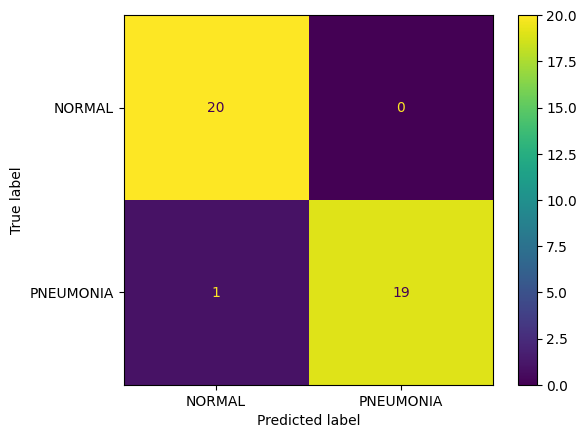

In [ ]:
# metrics
cm = ConfusionMatrixDisplay.from_predictions(true_class, y_pred_class, display_labels=test_generator.class_indices)
print('Classification Report:\n\n', classification_report(true_class, y_pred_class))

In [ ]:
# Random Validation

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0      # img_array = image_arr/255.0
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


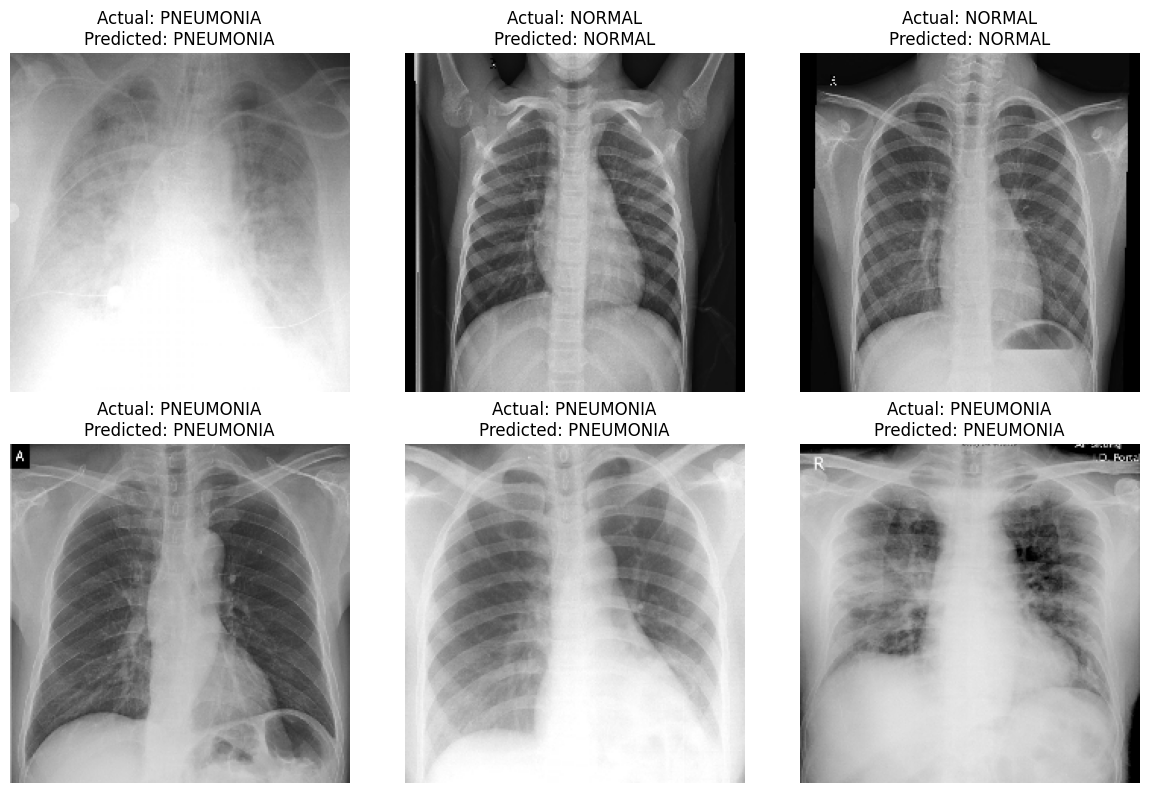

In [ ]:
# predictions for the random images
random_indices = random.sample(range(len(test_df)), 6)
random_images_path = test_df.iloc[random_indices]['FilePath'].tolist()
random_images_labels = test_df.iloc[random_indices]['Labels'].to_list()

images = [load_and_preprocess_image(img_path) for img_path in random_images_path]
images = np.vstack(images)

# predictions for the images
predictions = best_model.predict(images)
predicted_classes = predictions.argmax(axis=1)

class_labels = {v:k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_labels[idx] for idx in predicted_classes]

# plot figure for the predicitons
plt.figure(figsize=(12, 8))
for i, (img_path, actual_label) in enumerate(zip(random_images_path, random_images_labels)):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 3, i+1)
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')
    plt.imshow(img)
plt.tight_layout()
plt.show()